# Contextual Quantum Neural Network for Stock Pricing

## Preprocessing of data 
Convert log-returns into probability distribution of qubit features

In [1]:
import pandas as pd

VERBOSE = True

N_BINS = 2 # change from binary csv

df_binary = pd.read_csv("binary_stock_differences.csv")

print(df_binary.head())

   AAPL  AMZN  GOOG  MSFT
0     1     1     1     1
1     1     1     1     1
2     1     1     1     1
3     1     1     1     1
4     1     1     1     1


In [2]:

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','window'])
    
for context, ticker in enumerate(df_binary.columns):
        
    stock_series = df_binary[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]

        df.loc[len(df)] = [context, window.values]

print(df.head(15))

    context        window
0         0  [1, 1, 1, 1]
1         0  [1, 1, 1, 1]
2         0  [1, 1, 1, 1]
3         0  [1, 1, 1, 1]
4         0  [1, 1, 1, 1]
5         0  [1, 1, 1, 0]
6         0  [1, 1, 0, 1]
7         0  [1, 0, 1, 0]
8         0  [0, 1, 0, 0]
9         0  [1, 0, 0, 0]
10        0  [0, 0, 0, 0]
11        0  [0, 0, 0, 0]
12        0  [0, 0, 0, 0]
13        0  [0, 0, 0, 0]
14        0  [0, 0, 0, 0]


In [3]:
# split into train and test sets

TRAIN_RATIO = 0.8  # take the first 80% of df as requested

# Compute split index using the row order (first 80%)
n_rows = len(df)
split_index = int(n_rows * TRAIN_RATIO)

# First 80% (preserve original order); create df_test for remainder
df_train = df.iloc[:split_index].reset_index(drop=True)
df_test = df.iloc[split_index:].reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(4803, 2)
(1201, 2)



Probability distribution of feature patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0]    |      0.253 |  1216
[0,0,1]    |      0.070 |   336
[0,1,0]    |      0.025 |   122
[0,1,1]    |      0.076 |   366
[1,0,0]    |      0.070 |   337
[1,0,1]    |      0.032 |   153
[1,1,0]    |      0.077 |   368
[1,1,1]    |      0.397 |  1905

Total probability: 1.000000
Total samples: 4803


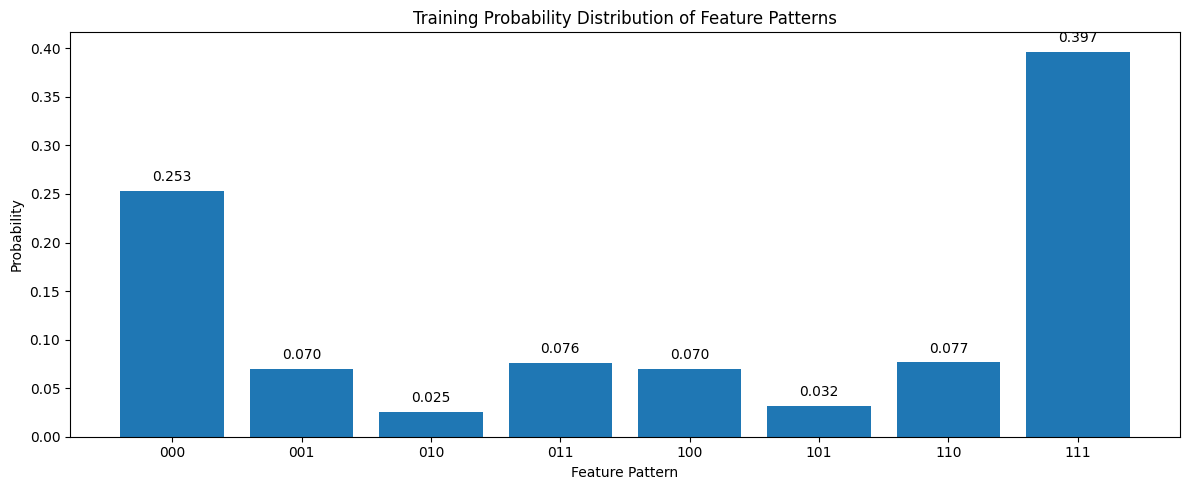


Probability distribution of output patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0,0]  |      0.197 |   944
[0,0,0,1]  |      0.057 |   272
[0,0,1,0]  |      0.016 |    77
[0,0,1,1]  |      0.054 |   259
[0,1,0,0]  |      0.016 |    78
[0,1,0,1]  |      0.009 |    44
[0,1,1,0]  |      0.015 |    70
[0,1,1,1]  |      0.062 |   296
[1,0,0,0]  |      0.057 |   273
[1,0,0,1]  |      0.013 |    64
[1,0,1,0]  |      0.010 |    46
[1,0,1,1]  |      0.022 |   107
[1,1,0,0]  |      0.054 |   259
[1,1,0,1]  |      0.023 |   109
[1,1,1,0]  |      0.062 |   299
[1,1,1,1]  |      0.334 |  1606

Total probability: 1.000000
Total samples: 4803


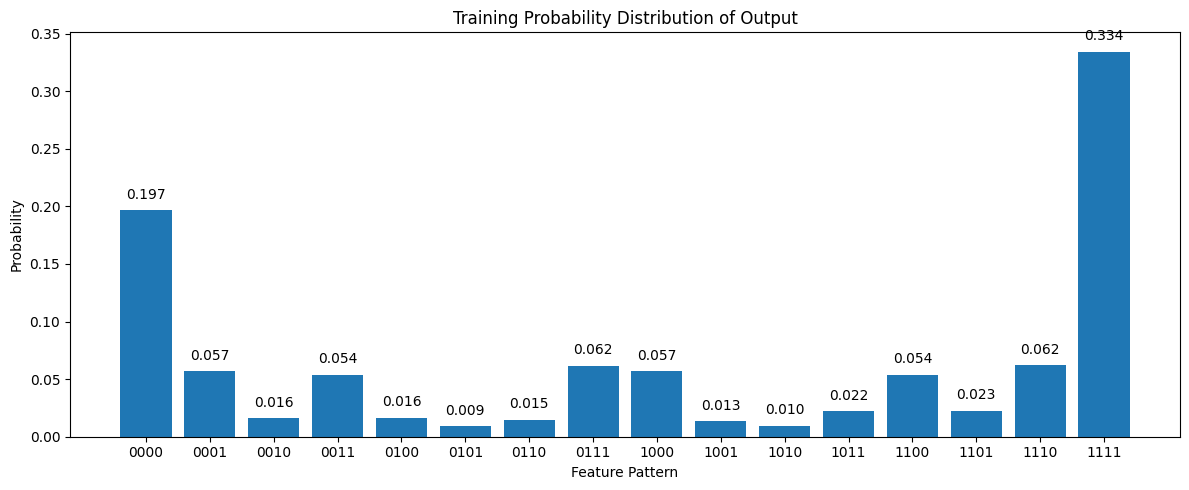

Text(0.5, 1.0, 'Distribution of Contexts')

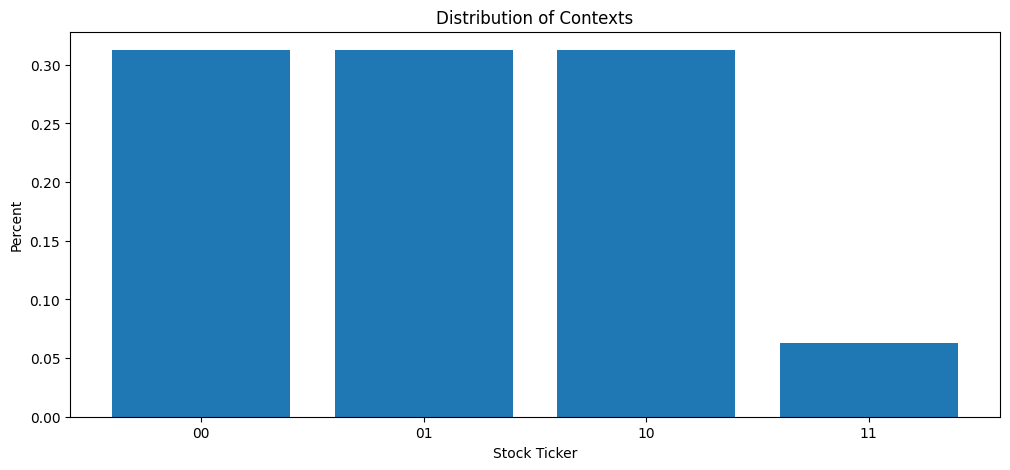

In [4]:
# Analyze global probability distribution of feature patterns
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

# Get dimensions
n_features = WINDOW_SIZE - 1  # Should be 3
n_feat_patterns = 2**n_features  # 8 possible patterns for 3 binary features

# Generate all possible patterns in natural binary order
feat_patterns = np.array(list(product([0, 1], repeat=n_features)))
feat_pattern_strs = [''.join(map(str, p)) for p in feat_patterns]

# Stack all feature vectors into a 2D array
all_features = np.stack(df_train['window'].apply(lambda x: x[:WINDOW_SIZE-1]))

# Count occurrences of each pattern
feature_counts = np.zeros(n_feat_patterns)
for i, pattern in enumerate(feat_patterns):
    matches = np.all(all_features == pattern, axis=1)
    feature_counts[i] = np.sum(matches)

# Convert to probabilities
feature_probs = feature_counts / feature_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of feature patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_feat_patterns):
        pattern_str = f"[{','.join(map(str, feat_patterns[i]))}]"
        print(f"{pattern_str:10s} | {feature_probs[i]:10.3f} | {int(feature_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {feature_probs.sum():.6f}")
print(f"Total samples: {int(feature_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(feat_pattern_strs, feature_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Feature Patterns')

# Add probability values on top of bars
for i, v in enumerate(feature_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

#Do the same thing but for target output probabilities
# Get dimensions
n_window = WINDOW_SIZE  # Should be 4
n_out_patterns = 2**n_window  # 16 possible patterns for 4 binary features

# Generate all possible patterns in natural binary order
out_patterns = np.array(list(product([0, 1], repeat=n_window)))
out_pattern_strs = [''.join(map(str, p)) for p in out_patterns]

# Stack all feature vectors into a 2D array
all_windows = np.stack(df_train['window'])

# Count occurrences of each pattern
window_counts = np.zeros(n_out_patterns)
for i, pattern in enumerate(out_patterns):
    matches = np.all(all_windows == pattern, axis=1)
    window_counts[i] = np.sum(matches)

# Convert to probabilities
output_probs = window_counts / window_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of output patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_out_patterns):
        pattern_str = f"[{','.join(map(str, out_patterns[i]))}]"
        print(f"{pattern_str:10s} | {output_probs[i]:10.3f} | {int(window_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {output_probs.sum():.6f}")
print(f"Total samples: {int(window_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(out_pattern_strs, output_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Output')

# Add probability values on top of bars
for i, v in enumerate(output_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# get context distribution
n_context = np.log2(df_binary.shape[1]).astype(int)

context_states = np.array(list(product([0, 1], repeat=n_context)))
context_states = [''.join(map(str, p)) for p in context_states]

context_dist = df_train['context'].value_counts(normalize=True).sort_index()
plt.figure(figsize=(12,5))
plt.bar(context_states, context_dist)
plt.ylabel('Percent')
plt.xlabel('Stock Ticker')
plt.title('Distribution of Contexts')

## Create state-preparation circuit to load input probability distribution into an approximate quantum state

In [5]:
# State preparation circuit (hardware-efficient ansatz)
import pennylane as qml

L_SP = 2 # number of layers for state preparation ansatz
N_WIRES_SP = WINDOW_SIZE - 1  # 3 qubits for 3 features

dev_sp = qml.device("default.qubit", wires=N_WIRES_SP)

def hardware_efficient_ansatz(params, n_wires=N_WIRES_SP):
    #Hadamard layer
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    #Optimization layers
    for l in range(L_SP):
        for i in range(n_wires):
            qml.RY(params[l][i][0], wires=i)
            qml.RZ(params[l][i][1], wires=i)

        for j in range(n_wires):
            qml.CNOT(wires=[j, (j + 1) % n_wires])

@qml.qnode(dev_sp, interface='torch', diff_method='spsa')
def sp_circuit(params):

    hardware_efficient_ansatz(params)

    return qml.probs(wires=range(N_WIRES_SP))

Starting SPSA training for state preparation...
Epoch 10 - MSE Loss: 0.006058303 - Best: 0.006058303 - Stalled: 0/100
Epoch 20 - MSE Loss: 0.001908347 - Best: 0.001908347 - Stalled: 0/100
Epoch 30 - MSE Loss: 0.001079882 - Best: 0.000912270 - Stalled: 5/100
Epoch 20 - MSE Loss: 0.001908347 - Best: 0.001908347 - Stalled: 0/100
Epoch 30 - MSE Loss: 0.001079882 - Best: 0.000912270 - Stalled: 5/100
Epoch 40 - MSE Loss: 0.000797753 - Best: 0.000797753 - Stalled: 0/100
Epoch 50 - MSE Loss: 0.000199647 - Best: 0.000199647 - Stalled: 0/100
Epoch 40 - MSE Loss: 0.000797753 - Best: 0.000797753 - Stalled: 0/100
Epoch 50 - MSE Loss: 0.000199647 - Best: 0.000199647 - Stalled: 0/100
Epoch 60 - MSE Loss: 0.000052493 - Best: 0.000052493 - Stalled: 0/100
Epoch 70 - MSE Loss: 0.000036816 - Best: 0.000036816 - Stalled: 0/100
Epoch 60 - MSE Loss: 0.000052493 - Best: 0.000052493 - Stalled: 0/100
Epoch 70 - MSE Loss: 0.000036816 - Best: 0.000036816 - Stalled: 0/100
Epoch 80 - MSE Loss: 0.000023170 - Best: 0

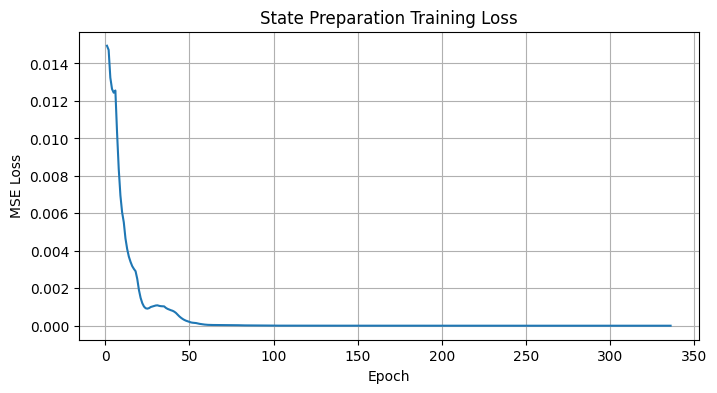

In [9]:
# Train the hardware-efficient ansatz to prepare the target probability distribution using PennyLane's SPSA optimizer
import torch
import torch.nn as nn

N_EPOCHS_SP = 10000
LEARNING_RATE_SP = 0.1
INIT_PARAM_SCALE = 0.01
PATIENCE_SP = 100  # early-stopping patience (epochs)
MIN_DELTA_SP = 1e-8  # minimum improvement to reset patience

target_probs = torch.tensor(feature_probs, dtype=torch.float64)

# Initialize parameters as a NumPy array
params_sp = nn.Parameter(torch.randn(L_SP, N_WIRES_SP, 2) * INIT_PARAM_SCALE)

# Create SPSA optimizer
opt_sp = torch.optim.Adam([params_sp], lr=LEARNING_RATE_SP)

loss_fn_sp = nn.MSELoss()

# Training loop using SPSA optimizer with early stopping
print("Starting SPSA training for state preparation...")
losses_sp = []

best_loss = float('inf')
epochs_no_improve = 0
# Keep a copy of best parameters (detached tensor)
best_params_sp = params_sp.detach().clone()

for epoch in range(N_EPOCHS_SP):
    # Single SPSA update step

    y_pred = sp_circuit(params_sp)

    loss = loss_fn_sp(y_pred, target_probs)

    loss.backward()

    opt_sp.step()

    opt_sp.zero_grad()

    loss_value = loss.item()
    losses_sp.append(loss_value)

    # Check improvement for early stopping
    if loss_value < best_loss - MIN_DELTA_SP:
        best_loss = loss_value
        epochs_no_improve = 0
        best_params_sp = params_sp.detach().clone()
    else:
        epochs_no_improve += 1

    # Print progress
    if (epoch + 1) % max(1, (PATIENCE_SP // 10)) == 0 or epoch == N_EPOCHS_SP - 1:
        print(f"Epoch {epoch+1} - MSE Loss: {loss_value:.9f} - Best: {best_loss:.9f} - Stalled: {epochs_no_improve}/{PATIENCE_SP}")

    # Early stopping check
    if epochs_no_improve >= PATIENCE_SP:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE_SP} epochs).")
        break

# After training, restore the best-found parameters
with torch.no_grad():
    params_sp.data.copy_(best_params_sp)

# Get final distribution
final_out = sp_circuit(params_sp)

# Detach from autograd graph for final printing/plotting
final_out_np = final_out.detach().numpy()
target_out_np = target_probs.detach().numpy()

print("Final state preparation parameters: ")
print(params_sp)

print("\nTarget probs:\n", np.round(target_out_np, 9))
print("Final prepared probs:\n", np.round(final_out_np, 9))

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses_sp) + 1), losses_sp)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('State Preparation Training Loss')
plt.grid(True)
plt.show()

[0.2531751  0.06995628 0.02540079 0.07620237 0.07016448 0.03185509
 0.07661878 0.39662711]
[0.25294313 0.07009806 0.0257258  0.075954   0.07038425 0.03212749
 0.07644001 0.39632726]


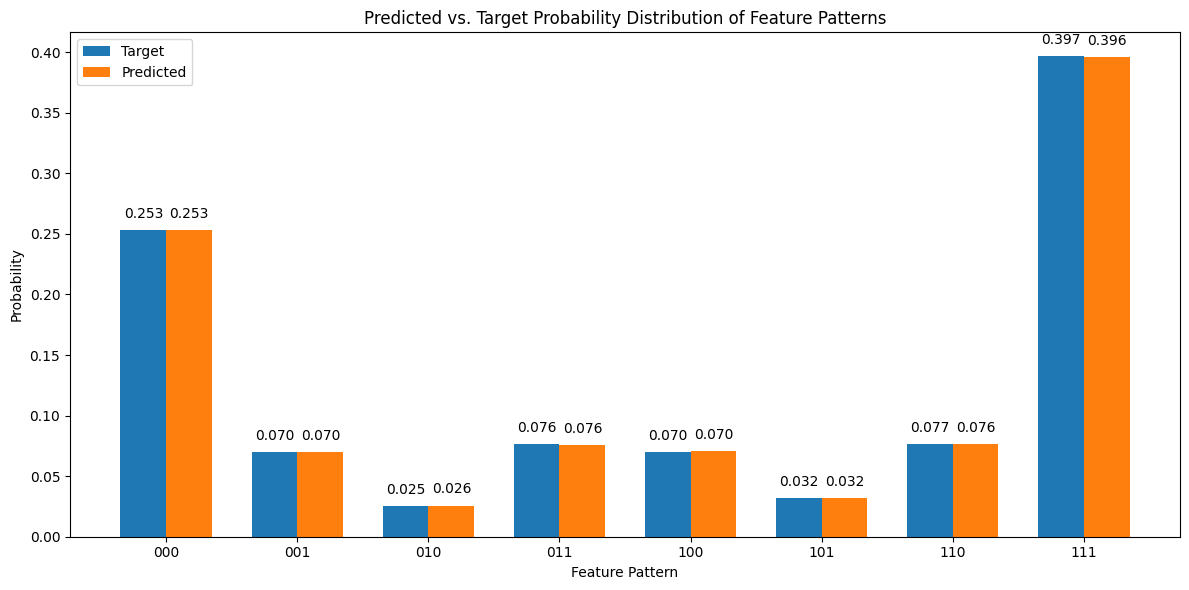

In [10]:
#Plot target probabilities and predicted probabilites
x = np.arange(len(feat_pattern_strs))
width = 0.35  # Width of the bars

print(target_out_np)
print(final_out_np)

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, target_out_np, width, label='Target')
plt.bar(x + width/2, final_out_np, width, label='Predicted')

plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Predicted vs. Target Probability Distribution of Feature Patterns')
plt.xticks(x, feat_pattern_strs)
plt.legend()

# Add probability values on top of bars
for i, (v1, v2) in enumerate(zip(target_out_np, final_out_np)):
    plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center')
    plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Create Prediction Circuit (Quantum Multi-Task Learning)

In [13]:
#Build the circuit

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = n_context  # Number of qubits needed to represent stocks
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_INPUT_WIRES = WINDOW_SIZE - N_OUTPUT_WIRES
N_TARGET_WIRES = N_INPUT_WIRES + N_OUTPUT_WIRES
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES + N_TARGET_WIRES + 1 #ancillary qubit

N_LAYERS = 2

input_wires = list(range(N_INPUT_WIRES))
output_wires = list(range(N_INPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES))
context_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES))
target_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES, N_TOTAL_WIRES - 1))
ancillary_wire = N_TOTAL_WIRES - 1
comp_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES))

# Define device using simulator for training
dev = qml.device("default.qubit", wires=N_TOTAL_WIRES)

def context_state_prep(wires):
    #Prepare context qubit state using percentages of each stock
    context_vect = np.array(np.sqrt(context_dist), dtype=complex)

    qml.StatePrep(context_vect, wires=wires)

def target_state_prep(wires):
    #Prepare target state using target output probability distribution
    output_vect = np.array(np.sqrt(output_probs), dtype=complex)

    qml.StatePrep(output_vect, wires=wires)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(comp_wires):
        qml.RY(params[i][0], wires=wire)
        qml.RZ(params[i][1], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(comp_wires)):
        qml.CNOT(wires=[comp_wires[i], comp_wires[(i + 1) % len(comp_wires)]])

def SWAP_test():
    qml.Hadamard(wires=ancillary_wire)

    for i in range(N_TARGET_WIRES):
        # CSWAP gate
        qml.CSWAP(wires=[ancillary_wire, comp_wires[i], target_wires[i]])
    
    qml.Hadamard(wires=ancillary_wire)

@qml.qnode(dev, interface='torch', diff_method='spsa')
def qmtl_circuit(params): # context is a classical input for now (what a drag...)
    
    # Approximate input state preparation
    hardware_efficient_ansatz(params_sp, N_INPUT_WIRES)

    #Exact target state preparation
    target_state_prep(target_wires)

    #Exact context state preparation
    context_state_prep(context_wires)

    qml.Barrier(range(N_TOTAL_WIRES))
    #Implement shared variational layers
    for l in range(N_LAYERS):
        U_ss(params['shared'][l])

    qml.Barrier(range(N_TOTAL_WIRES))
    # Implement control gates for specify layers
    for l in range(N_LAYERS):
        for context in context_states:
            qml.ctrl(lambda: U_ss(params['spec'][context][l]), control=context_wires, control_values=context)

    qml.Barrier(range(N_TOTAL_WIRES))
    
    # perform SWAP test
    SWAP_test()

    # Measure fidelity (1 - P(0) in ancillary qubit)
    return qml.probs(ancillary_wire)



--- Starting Training (with early stopping) ---
Epoch 10 - Fidelity Loss: 0.446821 - Best: 0.446821 - Stalled: 0/100
Epoch 10 - Fidelity Loss: 0.446821 - Best: 0.446821 - Stalled: 0/100
Epoch 20 - Fidelity Loss: 0.437538 - Best: 0.437538 - Stalled: 0/100
Epoch 20 - Fidelity Loss: 0.437538 - Best: 0.437538 - Stalled: 0/100
Epoch 30 - Fidelity Loss: 0.426126 - Best: 0.426126 - Stalled: 0/100
Epoch 30 - Fidelity Loss: 0.426126 - Best: 0.426126 - Stalled: 0/100
Epoch 40 - Fidelity Loss: 0.413934 - Best: 0.413934 - Stalled: 0/100
Epoch 40 - Fidelity Loss: 0.413934 - Best: 0.413934 - Stalled: 0/100
Epoch 50 - Fidelity Loss: 0.403268 - Best: 0.403268 - Stalled: 0/100
Epoch 50 - Fidelity Loss: 0.403268 - Best: 0.403268 - Stalled: 0/100
Epoch 60 - Fidelity Loss: 0.393218 - Best: 0.393218 - Stalled: 0/100
Epoch 60 - Fidelity Loss: 0.393218 - Best: 0.393218 - Stalled: 0/100
Epoch 70 - Fidelity Loss: 0.386291 - Best: 0.386291 - Stalled: 0/100
Epoch 70 - Fidelity Loss: 0.386291 - Best: 0.386291 - 

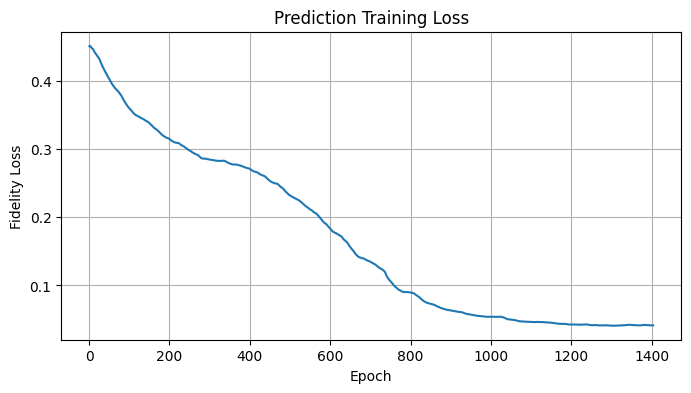

In [15]:
#Train prediction circuit

LEARNING_RATE = 0.01
# We use a large max epoch but rely on early stopping
N_EPOCHS = 10000
PATIENCE = 100  # early-stopping patience (epochs)
MIN_DELTA = 1e-6  # minimum improvement required to reset patience

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(comp_wires) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
params = init_params()

optimizer = torch.optim.Adam(params.values(), lr=LEARNING_RATE)

def fidelity_loss(params):
    # Run circuit
    y_pred = qmtl_circuit(params)

    return 1 - y_pred[0]  # Fidelity loss: 1 - P(0)

print("\n--- Starting Training (with early stopping) ---")
# --- Run Epochs ---
loss_hist = []
best_loss = float('inf')
epochs_no_improve = 0
# Keep a copy of best params (as detached clones)
best_params = {k: v.detach().clone() for k, v in params.items()}

for epoch in range(N_EPOCHS):
    # Do Quantum Batch Gradient Update (QBGU)
    loss = fidelity_loss(params)

    # Calculate Gradients
    # PyTorch and PennyLane work together to run the parameter-shift rule for ALL parameters.
    loss.backward()

    # Update parameters
    optimizer.step()

    # Clear gradients
    optimizer.zero_grad()

    loss_value = loss.item()
    loss_hist.append(loss_value)

    # Check improvement for early stopping
    if loss_value < best_loss - MIN_DELTA:
        best_loss = loss_value
        epochs_no_improve = 0
        # save best params
        best_params = {k: v.detach().clone() for k, v in params.items()}
    else:
        epochs_no_improve += 1

    # Print progress
    if (epoch + 1) % max(1, (PATIENCE // 10)) == 0 or epoch == N_EPOCHS - 1:
        print(f"Epoch {epoch+1} - Fidelity Loss: {loss_value:.6f} - Best: {best_loss:.6f} - Stalled: {epochs_no_improve}/{PATIENCE}")

    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs).")
        break

# After training, restore the best-found parameters
with torch.no_grad():
    for k in params.keys():
        params[k].data.copy_(best_params[k])

print("--- Training Complete ---")
print("Final Parameters (Shared):")
print(params['shared'])
print("Final Parameters (Specify):")
print(params['spec'])

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_hist) + 1), loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Fidelity Loss')
plt.title('Prediction Training Loss')
plt.grid(True)
plt.show()

In [16]:
#Plot the final circuit

# 0: Input 1
# 1: Input 2
# 2: Input 3
# 3: Output
# 4: Context 1
# 5: Context 2
# 6: Target 1
# 7: Target 2
# 8: Target 3
# 9: Target 4 (output)
# 10: Ancillary

print(qml.draw(qmtl_circuit)(params))

 0: ──H────RY(-0.16)──RZ(0.49)──╭●────╭X──RY(-0.65)──RZ(-0.31)─╭●────╭X─╭||──RY(1.32)─ ···
 1: ──H────RY(0.34)───RZ(0.46)──╰X─╭●─│───RY(0.08)───RZ(0.66)──╰X─╭●─│──├||──RY(-2.05) ···
 2: ──H────RY(-0.12)──RZ(-0.15)────╰X─╰●──RY(-0.97)──RZ(-0.32)────╰X─╰●─├||──RY(0.40)─ ···
 3: ────────────────────────────────────────────────────────────────────├||──RY(-0.39) ···
 4: ─╭|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
 5: ─╰|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
 6: ─╭|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
 7: ─├|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
 8: ─├|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
 9: ─╰|Ψ⟩───────────────────────────────────────────────────────────────├||─────────── ···
10: ────────────────────────────────────────────────────────────────────╰||─────────── ···